# Constructing a Fixed Effect Regression Estimator

While there are a number of useful statistical packages, sometimes the tools they provide don't quite sit at the right level of abstraction within a given domain. Consequently, it can be useful to build comfort with the construction of inferential tools, which involves a blend of computing and statistical knowledge. In the following exercise, we'll build a tool for ordinary least squares regression with fixed effects. To be clear, this kind of thing is pretty much offered off the shelf, but building it from scratch provides a few benefits:

+ It clarifies thinking about how such an estimator could be implemented
+ It forces consideration of software design, insofar as it should be constructed in a way that facilitates reuse across users and specific estimation contexts
+ Reference implementations exist to compare output

Even if such an estimator is coded up, it can be challenging to determine if it was built correctly. Consequently, there are two parts to this exercise. In the first part, the task is to simulate data from a known data generating process (i.e. the weights of each independent input into the model are known). Once the data are simulated, the second part involves construction of the estimator which will need to recover the weights from the noisy data provided from part one.

In [1]:
from dataclasses import dataclass, field
import numpy as np
from typing import List, Dict, Callable, Set, Optional, Tuple
import seaborn as sb
from collections import namedtuple, defaultdict, Counter
from IPython.display import IFrame
import pandas as pd
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import seaborn as sb
from patsy import dmatrices, DesignMatrix, DesignInfo

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Estimation of Home Values

First and foremost, you'll have to suspend some nuance in both the data generating process and the estimator to be produced, in service of keeping the example contained. Our goal is to estimate the value of a home given a data source that includes value, square footage, distance from center of the city, existence of a yard, and the city in which the home resides. 

$$h_i \sim f_i + d_i + y_i + c_i$$ 
where

+ $h$ is home values (\$)
+ $f \sim Normal(\mu, \sigma)$ is square footage
+ $d \sim HalfNormal(\mu, \sigma)$ is distance to center of the city (positive miles)
+ $y \sim Binomial(p)$ is existence of yard
+ $c \sim Uniform(low, high)$ is city of residence

### Variance by City

We expect structural variation in home values by city, so you'll need to work that into the data. In particular, you will need to peg the average home value in the cities you choose. To keep it simple, choose four US cities and leverage [Zillow's](https://www.zillow.com/research/data/) Zillow Home Value Index for *single family homes*. 

In [2]:
IFrame(src="https://www.zillow.com/research/data/", width=1500, height=500)

Technically, this is not an average, but it can serve as one for our purposes. Just be sure to state which cities you have chosen, the ZHVI for each city, and the date for which the ZHVI applies. For example:

In [3]:
# ZHVI for Feb 28, 2022
avg_value: Dict[str, float] = {
    "New York": 740459.,
    "Houston": 256823.,
    "Pittsburgh": 230671.,
    "Washington": 814878.,
}

*Note that the averages we choose here **may not** be precisely reflected in our estimates.* As part of our design requirements, we'll require that the simulator must give back a known number of "good" observations (i.e. observations with home values we consider plausible). Straightforward pursuit of this goal can censor the distribution of home values on lower end (e.g. cutting out negative values), which will push the home value averages up.

## Simulation

The first class should simulate a data set that includes the dependent variable and all of the independent variables. It should be parametric in the parameters for each distribution, and the number of observations produced. The weights applied to each independent variable should also be provided. The `city` attribute of the `Weights` instance should hold the "average home value" for each city.

In [4]:
Normal = namedtuple("Normal", ["mu", "sigma"])
Binomial = namedtuple("Binomial", ["p"])

@dataclass
class Weights:
    sqft: float
    distance: float
    yard: float
    city: Dict[str, float]

Using the skeleton below, complete the class and use it to simulate the data to be used for estimation. In your implementation, be sure to adhere to the following requirements:

1. The simulated data must reflect the distributional assumptions encoded in the input attributes.
2. Good home values must be explicitly defined to, at least, clear the `min_home_val` threshold. Bad observations should not be included in the output.
3. The simulated data must have precisely the number of observations specified (i.e. `n`).
4. The average home values by city should *roughly* correspond to the average value chosen as a peg (use good judgment pursuant to the caveat about censoring).

It may be convenient to add attributes or methods in addition to those specified. Feel free to do so, but you must implement and use those identified below.

In [5]:
@dataclass
class EstData:
    y: DesignMatrix
    x: DesignMatrix
    
    
@dataclass
class DataSim:
    n: int
    weights: Weights
    sqft_params: Normal
    distance_params: Normal
    yard_params: Binomial
    noise_params: Normal = Normal(mu=0, sigma=100.)
    min_home_val: float = 1e5
    data: pd.DataFrame = field(init=False)
    
    def __post_init__(self) -> None:
        self._city_set: Set[str] = set(self.weights.city.keys())
        self._city: List[str] = DataSim.sim_city(self._city_set, self.n)
        self.data: pd.DataFrame = self.simulate()
        self._sim_avg_home_vals: Dict[str, float] = {
            c: self.data[self.data["city"] == c]["home_vals"].mean() for c in self._city_set
        }
        self._sim_city_cnts: Dict[str, int] = dict(Counter(self._city))
            
    def simulate(self) -> pd.DataFrame:
        
        center: Callable[[np.ndarray], np.ndarray] = lambda arr: (arr - arr.mean())
        city_count: Callable[[str], int] = lambda city: len(list(filter(lambda lab: lab == city, self._city)))
        
        def bad_obs(df: pd.DataFrame) -> Tuple[int, pd.DataFrame]:
            out_df: pd.DataFrame = df[df["home_vals"].apply(lambda hv: hv > self.min_home_val)]
            drop_count: pd.DataFrame = len(df) - len(out_df)
            return drop_count, out_df
        
        num_bad_obs_dropped: Dict[str, int] = defaultdict(int)
        
        def compute_city_values(city: str, obs_to_sim: int, old_df: Optional[pd.DataFrame] = None) -> pd.DataFrame:
            sqft: np.ndarray = DataSim.sim_sqft(params=self.sqft_params, n=obs_to_sim)
            dist: np.ndarray = DataSim.sim_distance(params=self.distance_params, n=obs_to_sim)
            yard: np.ndarray = DataSim.sim_yard(params=self.yard_params, n=obs_to_sim)
            noise: np.ndarray = DataSim.sim_noise(params=self.noise_params, n=obs_to_sim)
            home_vals: np.ndarray = (
                self.weights.sqft * center(sqft)
                + self.weights.distance * center(dist)
                + self.weights.yard * center(yard)
                + self.weights.city[city]
                + noise
            )
            city_df: pd.DataFrame = pd.DataFrame(dict(
                home_vals=home_vals,
                sqft=sqft,
                dist=dist,
                yard=yard
            ))
            city_df["city"] = city
            
            if old_df is not None:
                city_df = pd.concat([old_df, city_df])
            
            drop_count: int
            out: pd.DataFrame
            drop_count, out = bad_obs(city_df)
            
            if drop_count == 0:
                return out
            else:
                return compute_city_values(city=city, obs_to_sim=drop_count, old_df=out)
        
        sim_by_city: List[pd.DataFrame] = list(map(
            lambda city: compute_city_values(city, city_count(city)), 
            self._city_set
        ))
        consolidated: pd.DataFrame = (
            pd.concat(sim_by_city, axis=0)
            .sort_values(by="home_vals")
            .reset_index(drop=True)
        )
        return consolidated
        
    
    @staticmethod
    def sim_sqft(params: Normal, n: int) -> np.ndarray:
        return np.random.normal(loc=params.mu, scale=params.sigma, size=n)
    
    @staticmethod
    def sim_distance(params: Normal, n: int) -> np.ndarray:
        return np.abs(np.random.normal(loc=params.mu, scale=params.sigma, size=n))
    
    @staticmethod
    def sim_yard(params: Binomial, n: int) -> np.ndarray:
        return np.random.binomial(n=1, p=params.p, size=n)

    @staticmethod
    def sim_city(cities: Set[str], n: int) -> np.ndarray:
        return np.random.choice(list(cities), size=n)
                
    @staticmethod
    def sim_noise(params: Normal, n: int) -> np.ndarray:
        return np.random.normal(loc=params.mu, scale=params.sigma, size=n)
    
    def plot_dist(self, variable: str, city: Optional[str] = None, figsize: Tuple[int, int] = (15, 8), **kwargs) -> Axes:
        
        if city is None:
            series: pd.Series = self.data[variable]
        else:
            series: pd.Series = self.data[self.data["city"] == city][variable]
            
        avg_value: float = series.mean()
        
        fig: Figure
        ax: Axes
        fig, ax = plt.subplots(figsize=figsize)
        hist: Axes = sb.histplot(series, ax=ax, **kwargs)
        ax.set_title(f"{variable} - All Cities" if city is None else f"{variable} - {city}")
        ax.axvline(x=series.mean(), color="grey")
        ax.annotate(f"Avg: {'{:,.2f}'.format(series.mean())}", xy=(0.9*series.max(), 0.95*ax.get_ylim()[1]))
        return ax
    
    
known_coeffs: Weights = Weights(
    sqft=500.,
    distance=-1e5,
    yard=8e4,
    city=avg_value
)
sqft_p: Normal = Normal(mu=1500., sigma=300.)
dist_p: Normal = Normal(mu=0., sigma=2.5)
yard_p: Binomial = Binomial(p=0.3)
    
simulator: DataSim = DataSim(
    n=int(1e4),
    weights=known_coeffs,
    sqft_params=sqft_p,
    distance_params=dist_p,
    yard_params=yard_p
)
data: pd.DataFrame = simulator.data

data

,home_vals,sqft,dist,yard,city
0,1.000653e+05,1260.292016,1.828536,0,Pittsburgh
1,1.000732e+05,1298.673173,2.242005,0,Houston
2,1.001029e+05,1331.336446,2.492398,0,Houston
3,1.002652e+05,1579.055819,3.459970,0,Pittsburgh
4,1.004878e+05,1385.608772,2.673503,0,Houston
...,...,...,...,...,...
9995,1.373537e+06,2312.673925,0.327056,0,Washington
9996,1.374700e+06,2093.552628,0.019224,1,Washington
9997,1.376143e+06,2277.572696,0.126751,0,Washington
9998,1.388251e+06,2484.173690,0.977488,1,New York


With your data simulated, use your plot function (or other checks you may have created) to probe the suitability of the simulated data. Do the distributions make sense? For example, what is the distribution of home values?

<AxesSubplot:title={'center':'home_vals - New York'}, xlabel='home_vals', ylabel='Count'>

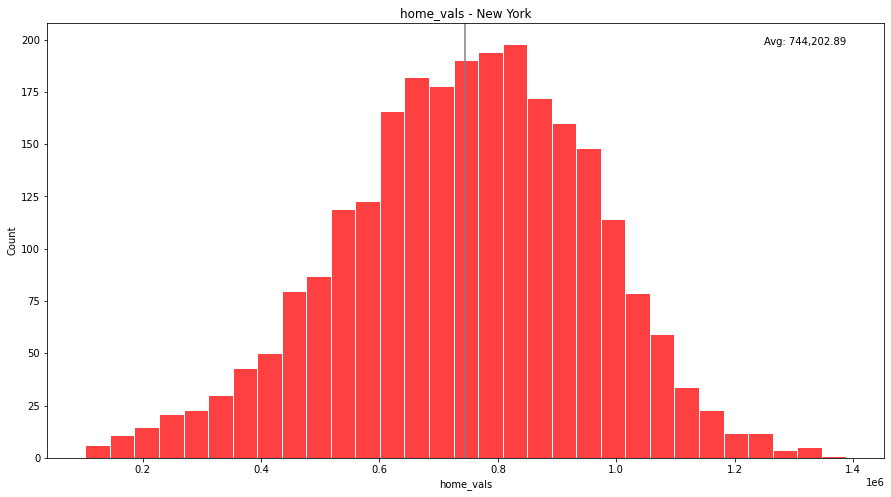

In [6]:
simulator.plot_dist(variable="home_vals", city="New York", color="red", edgecolor="white")

## Estimation

With data in hand, let's build the fixed effect estimator. For our purposes, we want to build the capability at three conceptual levels:

1. The estimator (`FixedEffectEstimator`), which can return results.
2. The results (`FEResults`), which holds the collection of estimation results.
3. Individual coefficient estimates (`CoefEst`), which provide distributional information about specific estimates.

Using the partially initialized code below, implement fixed effect regression in a way that adheres to the following requirements:

1. Outside of being able to consume an input as a `pandas DataFrame`, no further use of `pandas` is permitted. In other words, *no `pandas` methods or functions can be used* in the implementation.
2. The reported results must include the mean, standard error, and confidence interval for each estimate.
3. Standard errors should be computed by bootstrap.
4. Each estimate should be plottable, such that users can observe the variance in the estimate.

In [7]:
@dataclass
class CoefEst:
    name: str
    bootstrap_means: List[float]
    mean: float = field(default_factory=float)
    std_err: float = field(default_factory=float)
    ci_multiple: float = 1.96
    ci_lo: float = field(default_factory=float)
    ci_hi: float = field(default_factory=float)
    
    def __post_init__(self) -> None:
        self.mean: float = np.mean(self.bootstrap_means)
        self.std_err: float = np.std(self.bootstrap_means)
        self.ci_lo: float = self.mean - (self.ci_multiple * self.std_err)
        self.ci_hi: float = self.mean + (self.ci_multiple * self.std_err)
    
    def plot(self, ax: Axes, **kwargs) -> Axes:
        h: Axes = sb.histplot(x=self.bootstrap_means, ax=ax, **kwargs)
        ax.axvline(x=self.mean, color="black")
        for ci in [self.ci_lo, self.ci_hi]:
            ax.axvline(x=ci, color="grey", linestyle="--")
        return ax

@dataclass
class FEResults:
    bootstrap_weights: Dict[str, List[float]]
    estimates: List[CoefEst] = field(default_factory=list)
    
    def __post_init__(self) -> None:
        self.estimates: List[CoefEst] = [
            CoefEst(name=n, bootstrap_means=vals) for n, vals in self.bootstrap_weights.items()
        ]
        
    def plot_estimates(self, figsize: Tuple[int, int] = (15,5), **kwargs) -> Figure:
        fig: Figure
        ax: Axes
        
        fig, axes = plt.subplots(len(self.estimates), 1, figsize=(figsize[0], figsize[1]*len(self.estimates)))
        for i, est in enumerate(self.estimates):
            est_plot: Axes = est.plot(ax=axes[i], **kwargs)
            axes[i].set_title(f"{est.name}: {round(est.mean)}")
            
        return fig
            
    
@dataclass
class FixedEffectEstimator:
    in_data: pd.DataFrame
    bootstrap_draws: int = 100
    bootstrap_sample_size: Optional[int] = None
    
    def __post_init__(self) -> None:
        if self.bootstrap_sample_size is None:
            self.bootstrap_sample_size = int(0.75 * len(self.in_data))
    
    def to_spec(self, formula: str) -> EstData:
        y: DesignMatrix
        x: DesignMatrix
        y, x = dmatrices(formula, data=self.in_data)
        out: EstData = EstData(y=y, x=x)
        return out
    
    def fit(self, formula: str) -> FEResults:
        y: DesignMatrix
        x: DesignMatrix
        y, x = dmatrices(formula, data=self.in_data)
        out: FEResults = FixedEffectEstimator.bootstrap(
            y=y, 
            x=x, 
            num_draws=self.bootstrap_draws,
            sample_size=self.bootstrap_sample_size
        )
        return out
    
    @staticmethod
    def estimate(y: DesignMatrix, x: DesignMatrix) -> Dict[str, float]:
        xx_inv: np.ndarray = np.linalg.inv(np.matmul(np.transpose(x), x))
        xy: np.ndarray = np.matmul(np.transpose(x), y)
        est: np.ndarray = np.matmul(xx_inv, xy)
        out: Dict[str, float] = {
            x.design_info.column_names[i]: est[i][0] for i in range(est.shape[0])
        }
        return out
    
    @staticmethod
    def bootstrap(y: DesignMatrix, x: DesignMatrix, num_draws: int, sample_size: int) -> FEResults:
        def sample_est() -> Dict[str, float]:
            sample_idx: np.ndarray = np.random.choice(range(y.shape[0]), size=sample_size, replace=False)
            y_sample: np.ndarray = DesignMatrix(input_array=y[sample_idx], design_info=y.design_info)
            x_sample: np.ndarray = DesignMatrix(input_array=x[sample_idx], design_info=x.design_info)
            return FixedEffectEstimator.estimate(y_sample, x_sample)
        
        out_dict: Dict[str, List[float]] = defaultdict(list)
        for draw in range(num_draws):
            estimates: Dict[str, float] = sample_est()
            for variable, est_wt in estimates.items():
                out_dict[variable] += [est_wt]
                
        results: FEResults = FEResults(bootstrap_weights=dict(out_dict))
        return results
        
fe: FixedEffectEstimator = FixedEffectEstimator(in_data=data, bootstrap_draws=1000)
results: FEResults = fe.fit(formula="home_vals ~ sqft + dist + yard + C(city)")

Inspect the results of your estimation both by printing and plotting the output. To what extent do they correspond with the known weights?

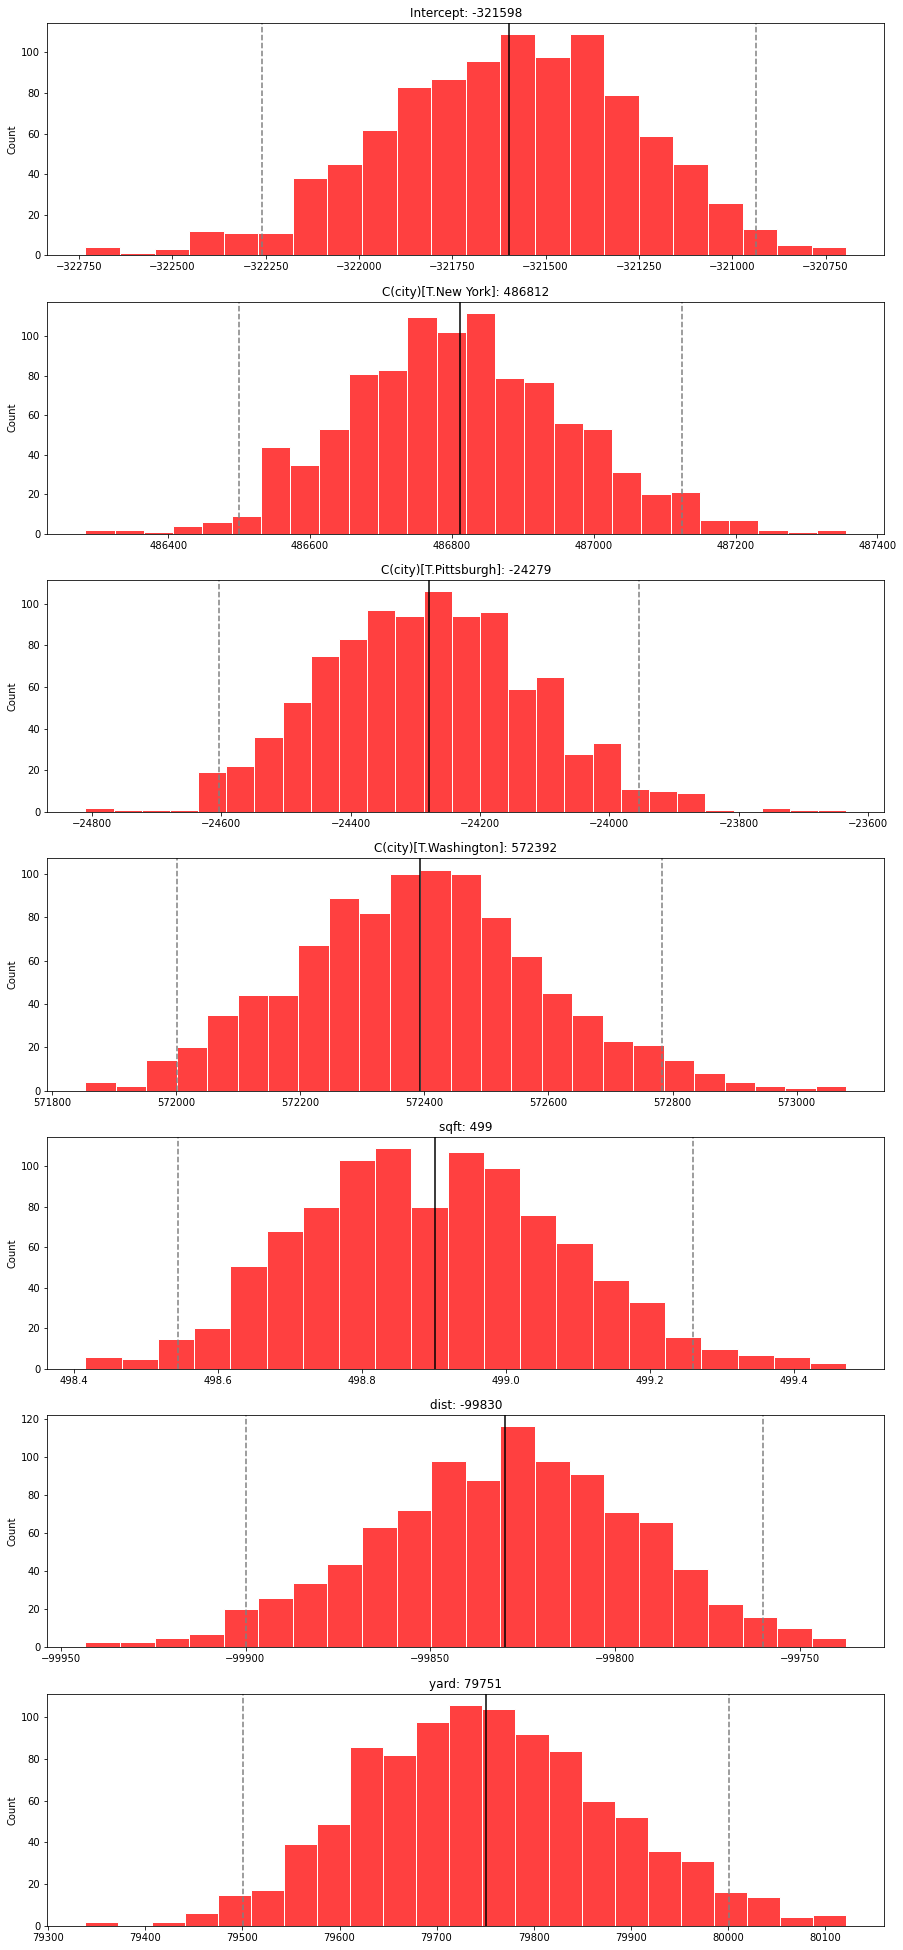

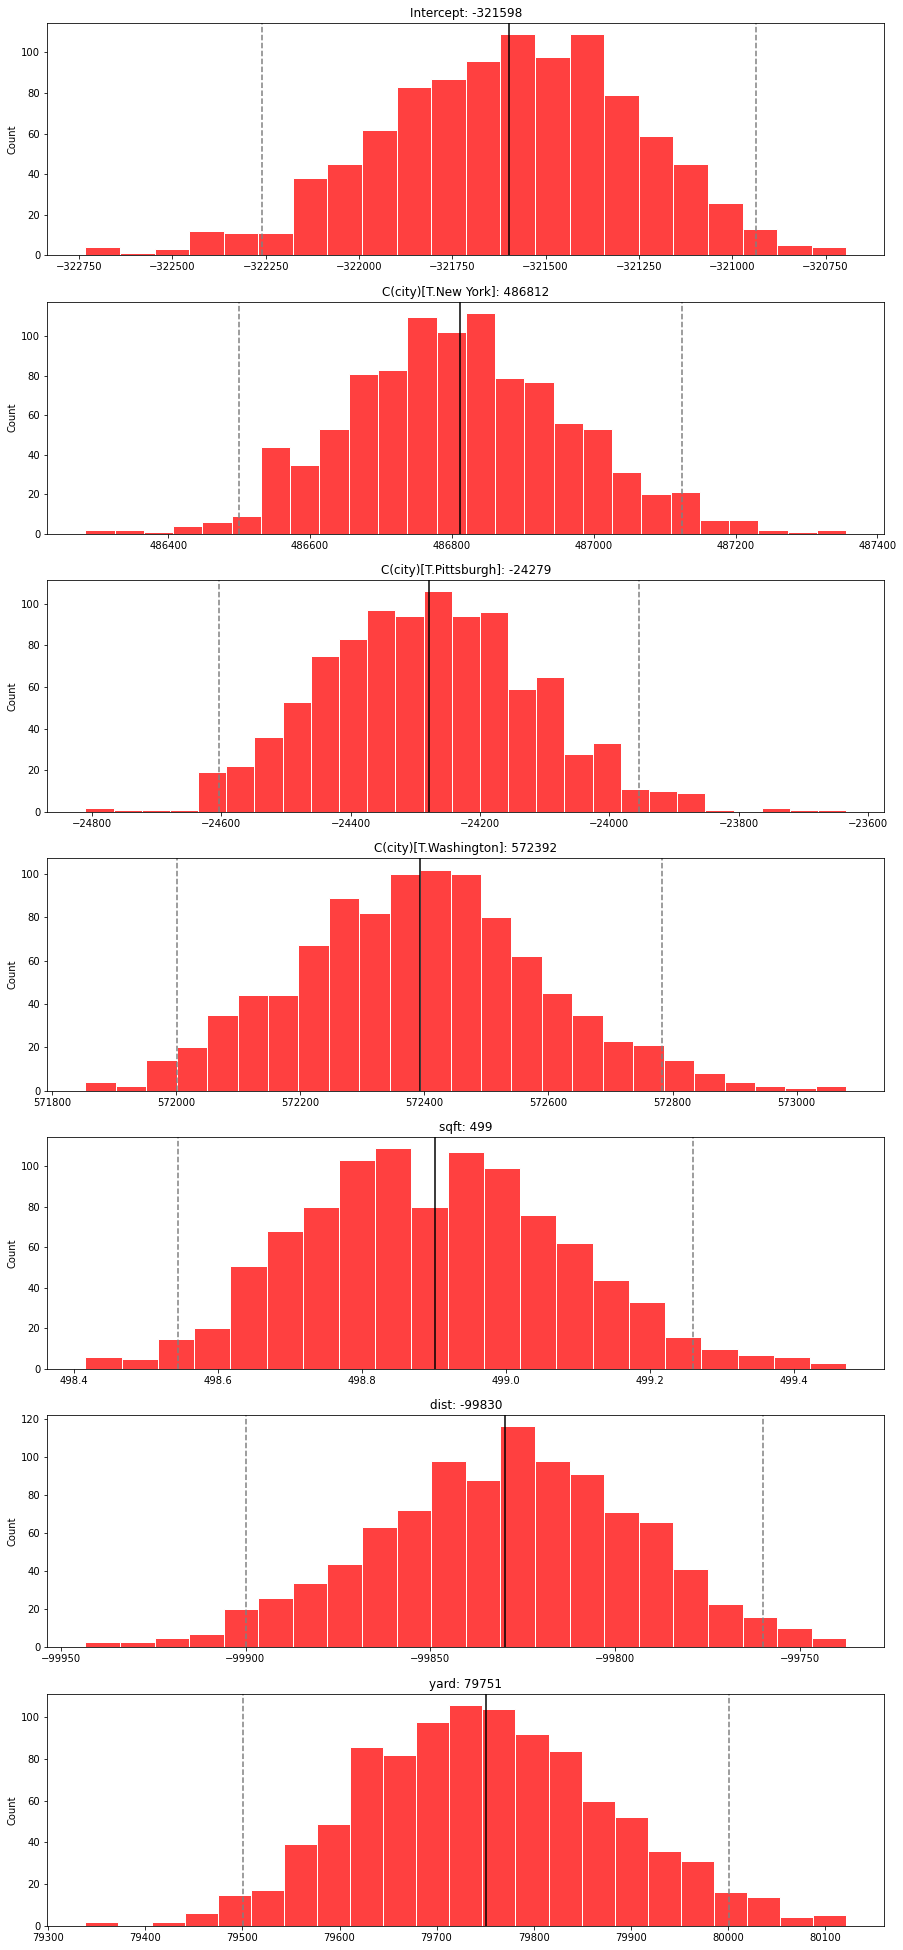

In [8]:
results.plot_estimates(color="red", edgecolor="white")